# Congestion Control at the Link Level

In [1]:
from src.helpers import run_with_mahi_settings, get_open_udp_port
from src.senders import Sender
from src.strategies import SenderStrategy, FixedWindowStrategy, TahoeStrategy, CubicStrategy

# Low BDP Tahoe - Droptail

[sender] Connected to receiver: 100.64.0.2:38280

Results for sender 53096:
Total Acks: 19350
Num Duplicate Acks: 556
% duplicate acks: 2.873385
Throughput (bytes/s): 12529.333333
Average RTT (ms): 245.942275


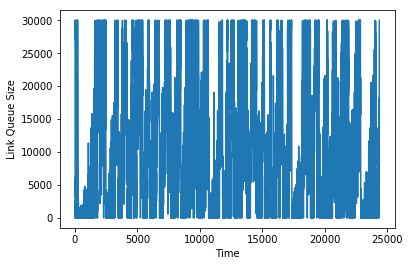

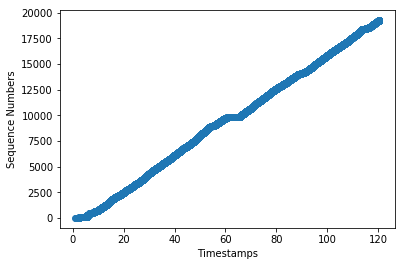

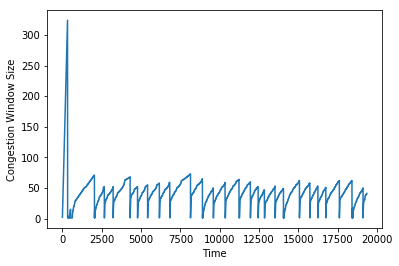

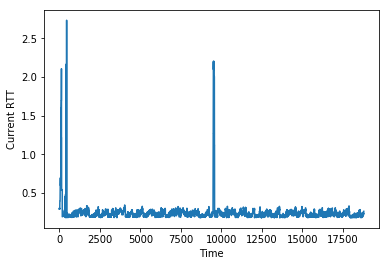

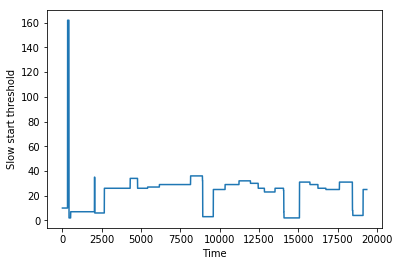

In [2]:
mahimahi_settings = {
    'delay': 88,
    'trace_file': '2.64mbps-poisson.trace',
    'queue_type': 'droptail',
    'downlink_queue_options': {
        'bytes': 30000
    }
}
port = get_open_udp_port()
strat = TahoeStrategy(10, 1)
run_with_mahi_settings(mahimahi_settings, 120, [Sender(port, strat)])

# Low BDP Tahoe - RED

[sender] Connected to receiver: 100.64.0.2:43199

Results for sender 39042:
Total Acks: 21827
Num Duplicate Acks: 515
% duplicate acks: 2.359463
Throughput (bytes/s): 14208.000000
Average RTT (ms): 225.778461


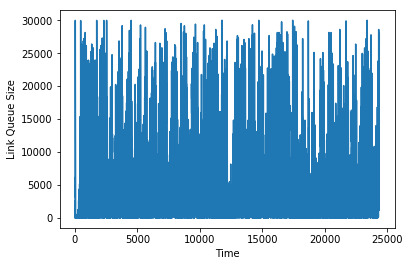

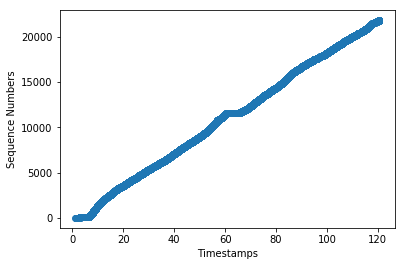

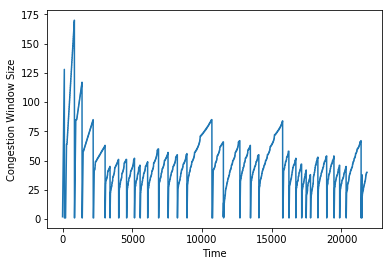

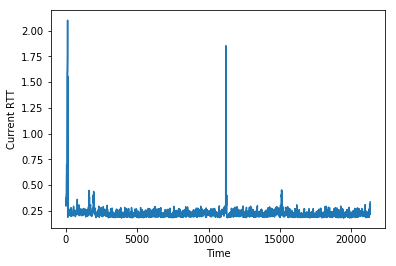

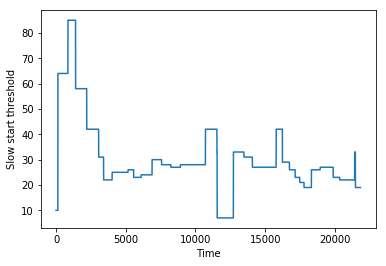

In [3]:
mahimahi_settings = {
    'delay': 88,
    'trace_file': '2.64mbps-poisson.trace',
    'queue_type': 'red',
    'downlink_queue_options': {
        'bytes': 30000,
        'wq': 0.002,
        'minthresh': 0.3,
        'maxthresh': 0.8
    }
}
port = get_open_udp_port()
strat = TahoeStrategy(10, 1)
run_with_mahi_settings(mahimahi_settings, 120, [Sender(port, strat)])

# Low BDP CUBIC - Droptail

[sender] Connected to receiver: 100.64.0.2:43940

Results for sender 42442:
Total Acks: 21607
Num Duplicate Acks: 886
% duplicate acks: 4.100523
Throughput (bytes/s): 13814.000000
Average RTT (ms): 252.107500


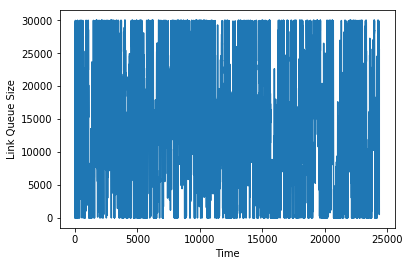

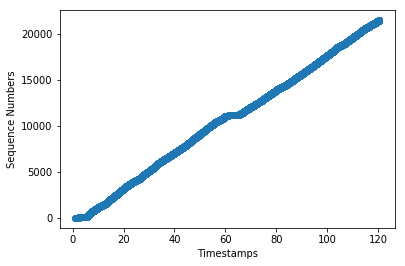

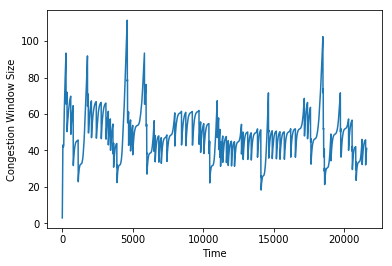

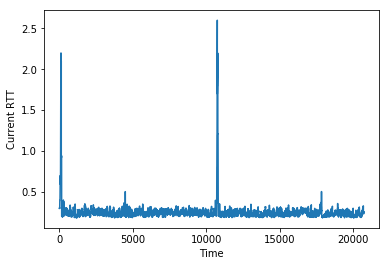

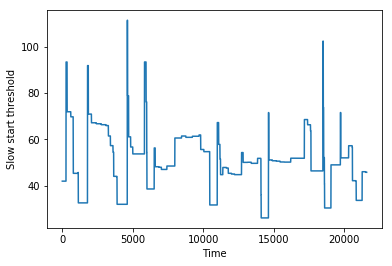

In [4]:
mahimahi_settings = {
    'delay': 88,
    'trace_file':'2.64mbps-poisson.trace',
    'queue_type': 'droptail',
    'downlink_queue_options': {
        'bytes': 30000
    }
}
port = get_open_udp_port()
strat = CubicStrategy(4)
run_with_mahi_settings(mahimahi_settings, 120, [Sender(port, strat)])

# Low BDP CUBIC - RED

[sender] Connected to receiver: 100.64.0.2:58918

Results for sender 32781:
Total Acks: 31503
Num Duplicate Acks: 1936
% duplicate acks: 6.145446
Throughput (bytes/s): 19711.333333
Average RTT (ms): 238.460575


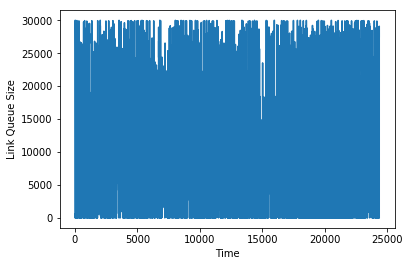

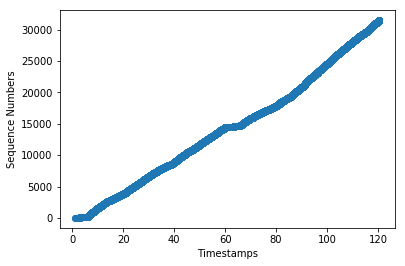

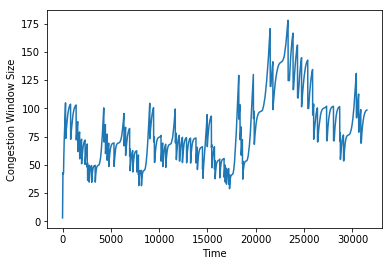

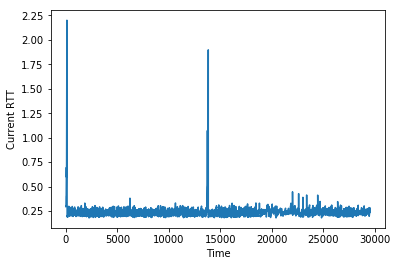

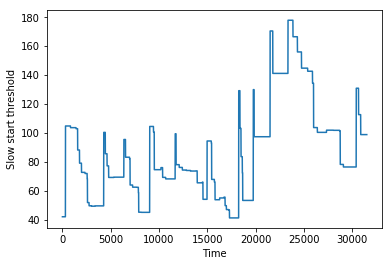

In [5]:

mahimahi_settings = {
    'delay': 88,
    'trace_file':'2.64mbps-poisson.trace',
    'queue_type': 'red',
    'downlink_queue_options': {
        'bytes': 30000,
        'wq': 0.002,
        'minthresh': 0.3,
        'maxthresh': 0.8
    }
}
port = get_open_udp_port()
strat = CubicStrategy(4)
run_with_mahi_settings(mahimahi_settings, 120, [Sender(port, strat)])

# High BDP CUBIC - Droptail

[sender] Connected to receiver: 100.64.0.6:40680

Results for sender 55819:
Total Acks: 26301
Num Duplicate Acks: 1268
% duplicate acks: 4.821109
Throughput (bytes/s): 16688.666667
Average RTT (ms): 448.255319


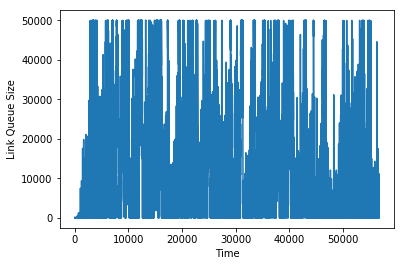

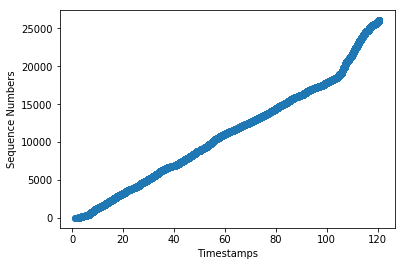

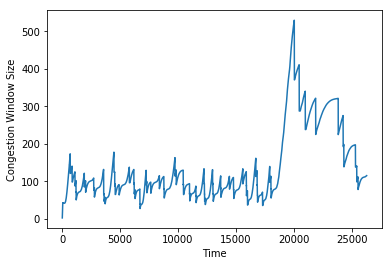

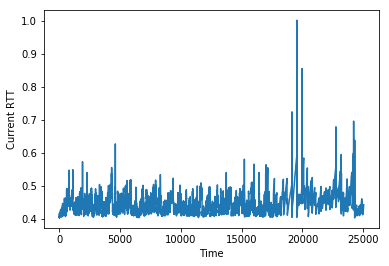

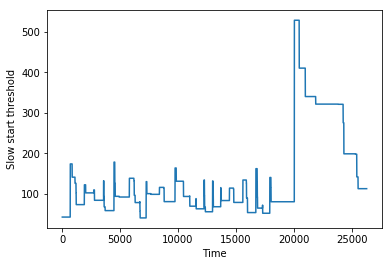

In [11]:
mahimahi_settings = {
    'delay': 200,
    'trace_file': '5.65mbps.trace',
    'queue_type': 'droptail',
    'downlink_queue_options': {
        'bytes': 50000
    }
}
port = get_open_udp_port()
strat = CubicStrategy(4)
run_with_mahi_settings(mahimahi_settings, 120, [Sender(port, strat)])

# High BDP CUBIC - RED

[sender] Connected to receiver: 100.64.0.8:33995

Results for sender 46426:
Total Acks: 62775
Num Duplicate Acks: 2364
% duplicate acks: 3.765830
Throughput (bytes/s): 40274.000000
Average RTT (ms): 489.931256


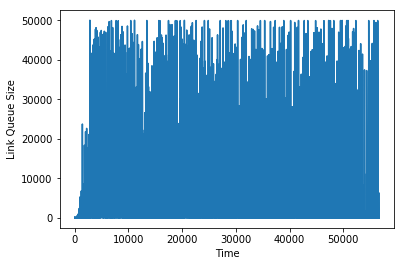

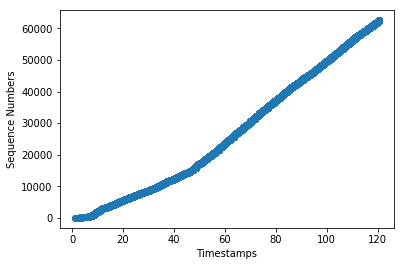

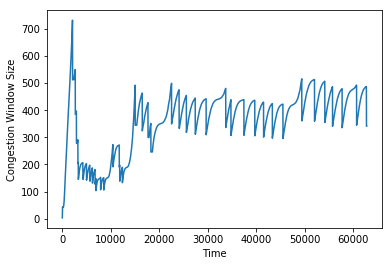

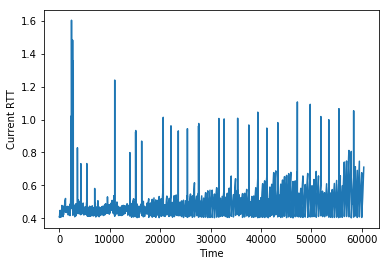

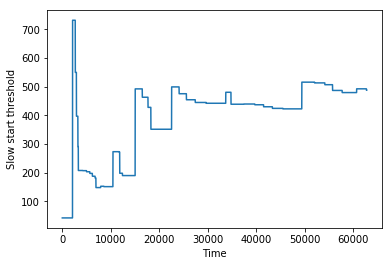

In [12]:
mahimahi_settings = {
    'delay': 200,
    'trace_file': '5.65mbps.trace',
    'queue_type': 'red',
    'downlink_queue_options': {
        'bytes': 50000,
        'wq': 0.002,
        'minthresh': 0.3,
        'maxthresh': 0.8
    }
}

port = get_open_udp_port()
strat = CubicStrategy(4)
run_with_mahi_settings(mahimahi_settings, 120, [Sender(port, strat)])

# High BDP Cubic vs Tahoe - Droptail

[sender] Connected to receiver: 100.64.0.4:34884

[sender] Connected to receiver: 100.64.0.4:34884

Results for sender 33403:
Total Acks: 70336
Num Duplicate Acks: 4095
% duplicate acks: 5.822054
Throughput (bytes/s): 44160.666667
Average RTT (ms): 543.329589


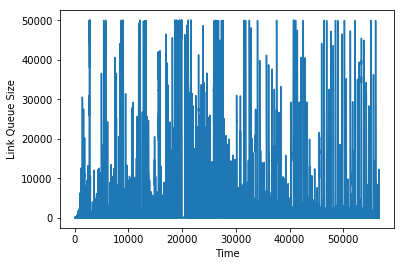

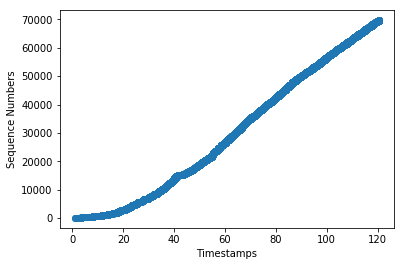

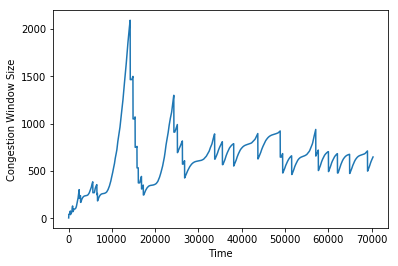

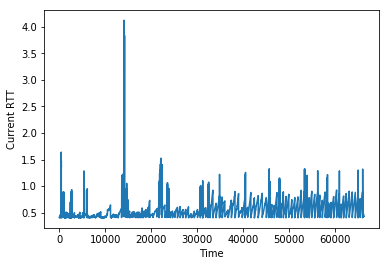

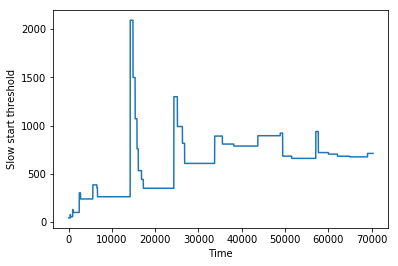


Results for sender 43191:
Total Acks: 12351
Num Duplicate Acks: 1541
% duplicate acks: 12.476723
Throughput (bytes/s): 7206.666667
Average RTT (ms): 506.192969


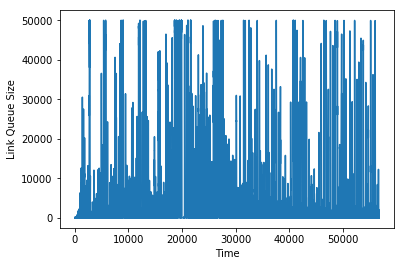

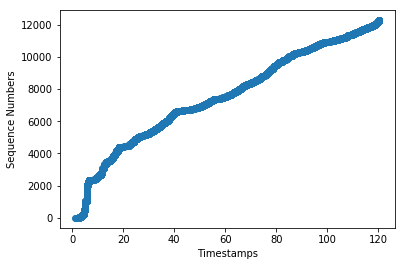

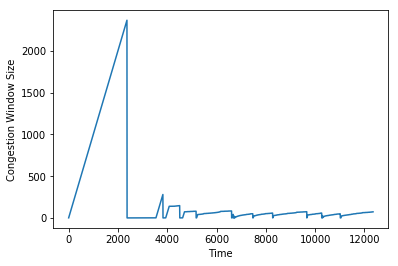

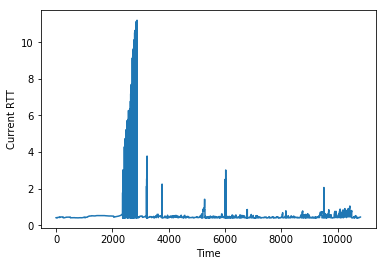

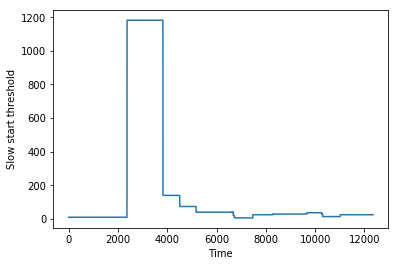

In [8]:
mahimahi_settings = {
    'delay': 200,
    'trace_file': '5.65mbps.trace',
    'queue_type': 'droptail',
    'downlink_queue_options': {
        'bytes': 50000
    }
}

port1 = get_open_udp_port()
strat1 = CubicStrategy(4)
port2 = get_open_udp_port()
strat2 = TahoeStrategy(10, 1)
run_with_mahi_settings(mahimahi_settings, 120, [Sender(port1, strat1), Sender(port2, strat2)])

# High BDP Cubic vs Tahoe - RED

[sender] Connected to receiver: 100.64.0.6:43165

[sender] Connected to receiver: 100.64.0.6:43165

Results for sender 38183:
Total Acks: 77372
Num Duplicate Acks: 4404
% duplicate acks: 5.691982
Throughput (bytes/s): 48645.333333
Average RTT (ms): 537.622024


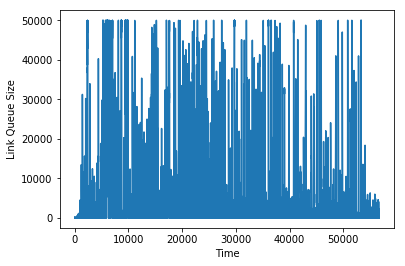

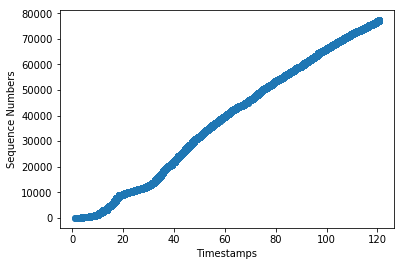

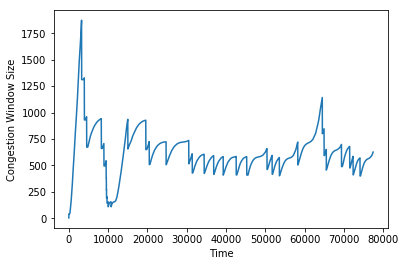

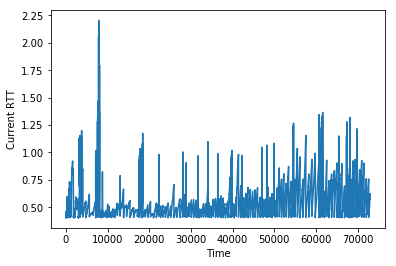

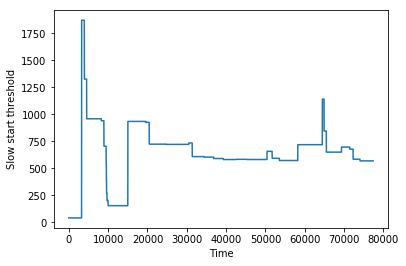


Results for sender 40936:
Total Acks: 11827
Num Duplicate Acks: 841
% duplicate acks: 7.110848
Throughput (bytes/s): 7324.000000
Average RTT (ms): 481.933732


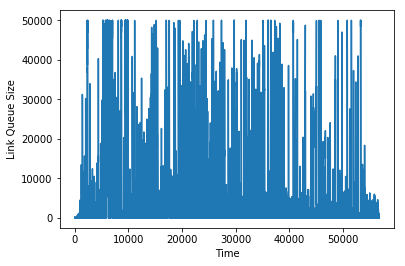

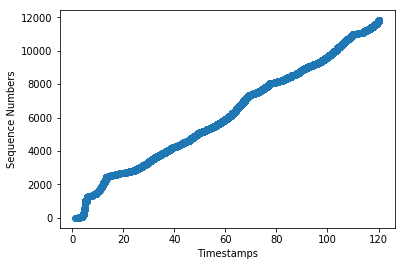

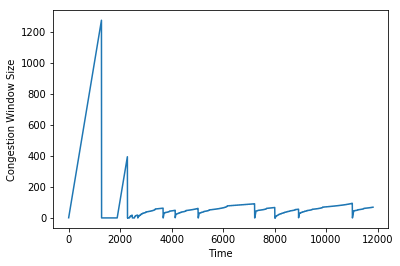

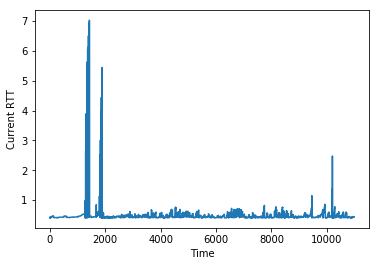

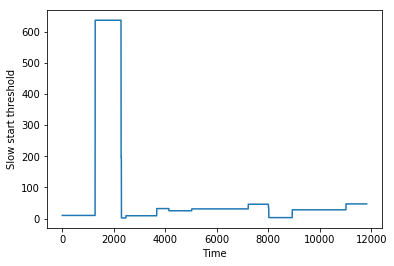

In [10]:
mahimahi_settings = {
    'delay': 200,
    'trace_file': '5.65mbps.trace',
    'queue_type': 'droptail',
    'downlink_queue_options': {
        'bytes': 50000,
        'wq': 0.002,
        'minthresh': 0.3,
        'maxthresh': 0.8
    }
}

port1 = get_open_udp_port()
strat1 = CubicStrategy(4)
port2 = get_open_udp_port()
strat2 = TahoeStrategy(10, 1)
run_with_mahi_settings(mahimahi_settings, 120, [Sender(port1, strat1), Sender(port2, strat2)])